# Joint LME models with surprisal and information value: dialogue corpora

In [1]:
### Import and utils
import ast
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ast import literal_eval
from pprint import pprint

# For local imports
import sys
sys.path.append('../../')
from utils import load_jsonl, load_surprise_data

# Plots
sns.set_palette('colorblind')
sns.set_style('white', {'font.family': 'Times New Roman'})
sns.set_context("paper", font_scale=2.5)

## Load data and preprocess

In [2]:
DATASETS = ['dailydialog', 'switchboard']

DATASET_CONTEXT_MAP = {
    'switchboard': 'switchboard/switchboard_results_is.jsonl',
    'dailydialog': 'dailydialog/dailydialog_results_is.jsonl',
    'BLL2018': 'BLL2018/processed_ratings.jsonl',
    'brown': 'RTs_5jun/brown_rt.jsonl',
    'ns': 'RTs_5jun/ns_rt.jsonl',
    'provo': 'RTs_5jun/provo_rt.jsonl',
}

CORPUS_NAMES = {
    'switchboard': 'Switchboard',
    'dailydialog': 'Dailydialog',
    'BLL2018': 'Clasp',
    'provo': 'Provo',
    'brown': 'Brown',
    'ns': 'Natural Stories',
}

MODEL_NAME_MAP = {
    'gpt2': 'GPT-2 Small',
    'gpt2-ft': 'GPT-2 Small Finetuned', # todo: remove
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2-large': 'GPT-2 Large',
    'dialogpt_small': 'DialoGPT Small',
    'dialogpt-small': 'DialoGPT Small',
    'dialogpt_medium': 'DialoGPT Medium',
    'dialogpt-medium': 'DialoGPT Medium',
    'dialogpt_large': 'DialoGPT Large',
    'dialogpt-large': 'DialoGPT Large',
    'opt_125m': 'OPT 125M',
    'opt-125m': 'OPT 125M',
    'opt_350m': 'OPT 350M',
    'opt-350m': 'OPT 350M',
    'opt_1.3b': 'OPT 1.3B',
    'opt-1.3b': 'OPT 1.3B',
    'gpt_neo_125m': 'GPT-Neo 125M',
    'gpt-neo-125m': 'GPT-Neo 125M',
    'gpt_neo_1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3B': 'GPT-Neo 1.3B',
}

SAMPLING_PARAM_MAP = {
    "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
    "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
}

SURPRISAL_COLUMNS = [
    'in_context_surprisal', 'out_of_context_surprisal', 'in_context_surprisal_rnd',
       'in_context_entropies', 'out_of_context_entropies', 'in_context_entropies_rnd',
       'in_context_deviations', 'out_of_context_deviations', 'in_context_deviations_rnd',
]


In [3]:
### Load data

dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprise/{dataset}"

    df = load_surprise_data(DATA_DIR)

    # Prettify column and value names
    df["corpus"] = df["corpus"].map(CORPUS_NAMES)
    df["sampling"] = df["sampling"].str.capitalize()
    df["sampling"] = df["sampling"].str.replace("Temp", "Temperature")

    df["model"] = df["model"].map(MODEL_NAME_MAP)

    sampling_param_map = {
        "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
        "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
    }
    df["sampling_param"] = df["sampling_param"].map(sampling_param_map)

    dfs.append(df)

surprise = pd.concat(dfs, axis=0, ignore_index=True)

# Set unique data point id for grouping
surprise["item_id"] = surprise.apply(lambda row: f"{row['context_id']}_{row['target_id']}", axis=1)


Loading data for dailydialog...
Size of dataset: 88000 rows
Loading data for switchboard...
Size of dataset: 88000 rows


In [4]:
POWER_RANGE = np.arange(0.5, 5.01, 0.25)

def local_diff(x):
    """from RUID"""
    d = 0
    for i in range(len(x)-1):
        d += abs(x[i+1]-x[i])
    return d

def power(x, y):
    """from RUID"""
#     if x.mask.all():
#         return np.nan
#     return np.nanmean(x**y)
    return np.nansum(x**y)

def load_surprisal_data(data_dir, columns, surprisal_columns):
    """
    Load data from a directory of CSV files containing surprisal estimates.
    # Arguments:
        data_dir (str): Path to directory containing CSV files.
        columns (list): columns to load from CSV files. If None, all columns are loaded.
        surprisal_columns (list): columns to format with ast (ugly but fine for now)
    """
    data = None
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            dset = data_dir.split('/')
            fp = os.path.join(data_dir, file)
            df = pd.read_csv(fp, usecols=columns)

            # Store with fields
            fields_from_name = fp.split('/')
            df['corpus'] = CORPUS_NAMES[fields_from_name[-2]]
            df['model'] = MODEL_NAME_MAP[fields_from_name[-1][:-4]]

            # literal eval
            for column in surprisal_columns:
                df[column] = df[column].apply(
                    lambda s: [
                        ast.literal_eval(x.strip(' []'))
                        for x in s.split() if x.strip(' []')
                    ]
                )

            if "data" in locals():
                data = pd.concat([data, df])
            else:
                data = df

    print(f"Size of dataset: {data.shape} rows, cols")

    # Add sequence surprisal aggregates
    surprise_cols = [c for c in data.columns if "in_" in c or "out_" in c]
    # print(surprise_cols)
    for col in surprise_cols:
        data[f'{col}_agg_sum'] = data[col].apply(np.sum)
        data[f'{col}_agg_variance'] = data[col].apply(np.var)
        data[f'{col}_agg_max'] = data[col].apply(np.amax)
        data[f'{col}_agg_mean'] = data[col].apply(np.mean)
        data[f'{col}_agg_ldiff'] = data[col].apply(local_diff)
        for p in POWER_RANGE:
            data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))

    print(f"Size of dataset: {data.shape} rows, cols")
    return data


In [5]:
cols = [
    'context_id', 'target_id' #, 'judgements', 'mean_acceptability', 'median_acceptability', 'real'
]
all_cols = cols + SURPRISAL_COLUMNS

all_surprisal_dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprisal/{dataset}"

    surprisal_df = load_surprisal_data(DATA_DIR, all_cols, SURPRISAL_COLUMNS)
    all_surprisal_dfs.append(surprisal_df)

surprisal = pd.concat(all_surprisal_dfs, axis=0, ignore_index=True)


Loading data for dailydialog...
Size of dataset: (800, 13) rows, cols


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: Perfo

Size of dataset: (800, 229) rows, cols
Loading data for switchboard...
Size of dataset: (800, 13) rows, cols


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: Perfo

Size of dataset: (800, 229) rows, cols


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/3296838058.py:63: Perfo

In [6]:
swb_one_df = surprise[
    (surprise['model'] == 'DialoGPT Large') &
    (surprise['corpus'] == 'Switchboard') &
    (surprise['sampling'] == 'Temperature') &
    (surprise['sampling_param'] == '1.25') &
    (surprise['n_samples'] == 100)
]

dd_one_df = surprise[
    (surprise['model'] == 'GPT-2 Large') &
    (surprise['corpus'] == 'Dailydialog') &
    (surprise['sampling'] == 'Nucleus') &
    (surprise['sampling_param'] == '0.9') &
    (surprise['n_samples'] == 100)
]

swb_one_df_surprisal = surprisal[
    (surprisal['model'] == 'DialoGPT Large') &
    (surprisal['corpus'] == 'Switchboard')
]

dd_one_df_surprisal = surprisal[
    (surprisal['model'] == 'GPT-2 Large') &
    (surprisal['corpus'] == 'Dailydialog')
]


for col in swb_one_df_surprisal.columns:
    if col not in swb_one_df.columns:
        swb_one_df[col] = swb_one_df_surprisal[col].tolist()

for col in dd_one_df_surprisal.columns:
    if col not in dd_one_df.columns:
        dd_one_df[col] = dd_one_df_surprisal[col].tolist()

swb_one_df['mutual_info'] = swb_one_df['in_context_surprisal_agg_mean'] - swb_one_df['out_of_context_surprisal_agg_mean']
dd_one_df['mutual_info'] = dd_one_df['in_context_surprisal_agg_mean'] - dd_one_df['out_of_context_surprisal_agg_mean']


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/2294778839.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swb_one_df[col] = swb_one_df_surprisal[col].tolist()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/2294778839.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swb_one_df[col] = swb_one_df_surprisal[col].tolist()
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/2294778839.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [7]:
len(swb_one_df), len(swb_one_df_surprisal), len(dd_one_df), len(dd_one_df_surprisal)

(100, 100, 100, 100)

In [8]:
# One row per judgement
swb_one_df['judgements'] = swb_one_df['judgements'].apply(literal_eval)
swb_one_df = swb_one_df.explode('judgements')
swb_one_df['judgements'] = pd.to_numeric(swb_one_df['judgements'])

dd_one_df['judgements'] = dd_one_df['judgements'].apply(literal_eval)
dd_one_df = dd_one_df.explode('judgements')
dd_one_df['judgements'] = pd.to_numeric(dd_one_df['judgements'])


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/984160285.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swb_one_df['judgements'] = swb_one_df['judgements'].apply(literal_eval)
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_81220/984160285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_one_df['judgements'] = dd_one_df['judgements'].apply(literal_eval)


## Statistical models

In [9]:
from statsmodels.formula.api import mixedlm

def get_mixedlm_results(data_df, y, X, group, baseline_rdict=None, nan_policy='fill'):
    """
    Fit a mixed linear model with y as the response variable and X as the predictor variables.
    The model is fit with group as a random effect.

    :param data_df: Dataframe containing estimates and psychometric data
    :param y: Response variable (a string)
    :param X: Predictor variables (a list of strings)
    :param group: Group variable (a string)
    :param baseline_rdict: Dictionary containing results of a baseline model (as returned by this function)
    :param nan_policy: How to handle NaN values in the data. Either 'omit' or 'fill'.
    :return: Tuple containing the model results (a statsmodel object) and a dictionary of results
    """
    if nan_policy == 'omit':
        data_df = data_df.dropna(subset=X)
    elif nan_policy == 'fill':
        data_df = data_df.fillna(1.0)
    else:
        raise ValueError(f"Invalid nan_policy: {nan_policy}")

    formula = f"{y} ~ {' + '.join([x for x in ['1'] + X])}"

    model = mixedlm(
        formula,
        data_df,
        groups=data_df[group]
    )

    result = model.fit(method=["bfgs"])
    result_dict = {}

    tvals = result.tvalues.to_dict()
    for k in tvals:
        if k != "Group Var":
            result_dict[f"Coeff {k}"] = tvals[k]

    pvals = result.pvalues.to_dict()
    for k in pvals:
        if k != "Group Var":
            result_dict[f"p-value {k}"] = pvals[k]

    result_dict["Group Var"] = tvals["Group Var"]
    result_dict["Residual Var"] = result.scale
    result_dict["Total Var"] = result_dict["Residual Var"] + result_dict["Group Var"]
    result_dict["Explained Var"] = result_dict["Group Var"] / result_dict["Total Var"]
    result_dict["Log-Likelihood"] = result.llf
    result_dict["Converged"] = result.converged

    if baseline_rdict:
        result_dict["Delta Log-Likelihood"] = result_dict["Log-Likelihood"] - baseline_rdict["Log-Likelihood"]

    return result, result_dict

In [10]:
def get_single_predictor_results(single_predictor_models, to_latex=False):
    # First, get the coefficients, p-values, and deltas.
    coefficients = []
    p_values = []
    deltas = []
    _metrics = []
    for metric in single_predictor_models:
        _metrics.append(metric)
        coefficients.append(single_predictor_models[metric][f'Coeff {metric}'])
        p_values.append(single_predictor_models[metric][f'p-value {metric}'])
        deltas.append(single_predictor_models[metric]['Delta Log-Likelihood'])

    # Then, make a dataframe.
    single_predictor_df = pd.DataFrame({
        'Metric': _metrics,
        'Coefficient': coefficients,
        'Delta Log-Likelihood': deltas,
        'p-value': p_values,
    })

    # Round coefficients and deltas to 3 decimal places.
    single_predictor_df['Coefficient'] = single_predictor_df['Coefficient'].apply(lambda x: round(x, 3))
    single_predictor_df['Delta Log-Likelihood'] = single_predictor_df['Delta Log-Likelihood'].apply(lambda x: round(x, 3))

    # Make a latex table using coefficients, p-values, and deltas. Add a star to coefficient if p-value < 0.001.
    single_predictor_df['Coefficient'] = single_predictor_df.apply(lambda x: f"{x['Coefficient']}{'*' if x['p-value'] < 0.01 else ''}{'*' if x['p-value'] < 0.001 else ''}", axis=1)

    # print table without p-values, rounded to 3 decimal places
    if to_latex:
        print(single_predictor_df[['Metric', 'Coefficient', 'Delta Log-Likelihood']].to_latex(index=False, float_format="%.3f"))

    return single_predictor_df


In [11]:
def plot_single_predictor_results(single_predictor_df):
    fig, ax = plt.subplots(figsize=(13, 5))
    sns.barplot(
        data=pd.DataFrame({
            "Metric": single_predictor_df['Metric'],
            "Delta Log-Likelihood": single_predictor_df['Delta Log-Likelihood']
        }),
        x="Metric",
        y="Delta Log-Likelihood",
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel("$\Delta$ Log-Likelihood")
    # rotate x tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [12]:
single_predictors_mixed = [
    'surprise_mean_1gram', 'surprise_mean_2gram', 'surprise_mean_3gram',
    'surprise_mean_1gram_pos', 'surprise_mean_2gram_pos', 'surprise_mean_3gram_pos',
    'surprise_mean_cosine', 'surprise_mean_euclidean',
    'surprise_min_1gram', 'surprise_min_2gram', 'surprise_min_3gram',
    'surprise_min_1gram_pos', 'surprise_min_2gram_pos', 'surprise_min_3gram_pos',
    'surprise_min_cosine', 'surprise_min_euclidean',
    'in_context_surprisal_agg_variance',
    'in_context_surprisal_agg_mean', 'in_context_surprisal_agg_max',
    'in_context_surprisal_agg_power_0_5', 'in_context_surprisal_agg_power_0_75',
    'out_of_context_surprisal_agg_sum', 'in_context_surprisal_agg_power_1_25',
    'in_context_surprisal_agg_power_1_5', 'in_context_surprisal_agg_power_1_75',
    'in_context_surprisal_agg_power_2_0', 'in_context_surprisal_agg_power_2_25',
    'in_context_surprisal_agg_power_2_5', 'in_context_surprisal_agg_power_2_75',
    'mutual_info'
]

delta_results = []

-----

## Switchboard

### Baseline model

In [13]:
swb_baseline_result, swb_baseline_rdict = get_mixedlm_results(
    swb_one_df,
    y='judgements',
    X=[],
    group='item_id'
)
print(swb_baseline_result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: judgements
No. Observations: 450     Method:             REML      
No. Groups:       100     Scale:              0.8186    
Min. group size:  2       Log-Likelihood:     -695.2714 
Max. group size:  7       Converged:          Yes       
Mean group size:  4.5                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  2.405     0.119  20.250  0.000   2.172   2.638
Group Var  1.219     0.248                               



### Single predictor models

In [14]:
swb_single_predictor_models = {}
for metric in tqdm(single_predictors_mixed):
    _, tmp_rdict = get_mixedlm_results(
        swb_one_df,
        y='judgements',
        X=[metric],
        group='item_id',
        baseline_rdict=swb_baseline_rdict
    )
    swb_single_predictor_models[metric] = tmp_rdict

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
swb_single_predictor_df = get_single_predictor_results(swb_single_predictor_models)

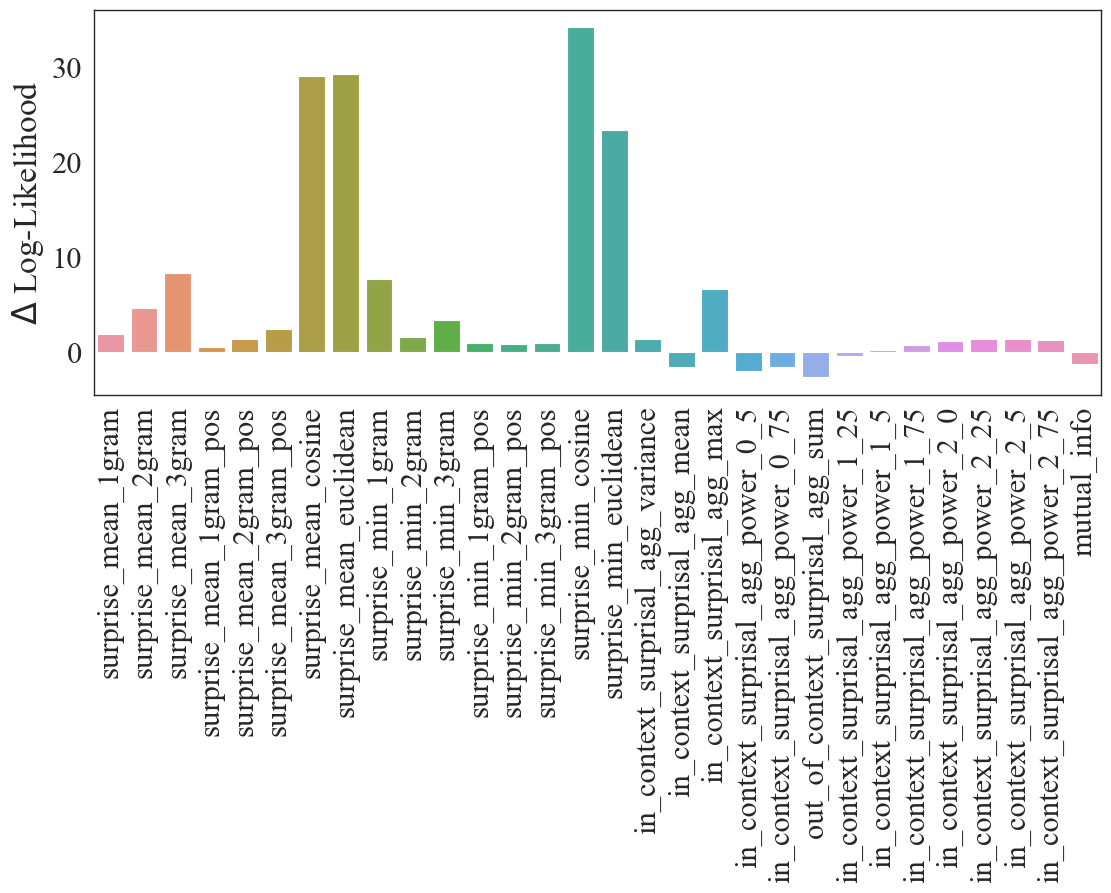

In [16]:
plot_single_predictor_results(swb_single_predictor_df)

In [17]:
swb_single_predictor_df[
    swb_single_predictor_df.Metric.str.contains("surprisal")
].sort_values('Delta Log-Likelihood', ascending=False).head(3)

,Metric,Coefficient,Delta Log-Likelihood,p-value
18,in_context_surprisal_agg_max,-4.35**,6.634,0.000014
27,in_context_surprisal_agg_power_2_5,-4.471**,1.451,0.000008
16,in_context_surprisal_agg_variance,-2.977*,1.432,0.002910


In [18]:
swb_measures_df = pd.read_csv('../analysis_sec6/dataframes/swb_measures.csv')
top_swb_measure = swb_measures_df[swb_measures_df['Delta Log-Likelihood'] == np.max(swb_measures_df['Delta Log-Likelihood'])]
top_swb_distances = eval(top_swb_measure['Distances'].tolist()[0])
top_swb_distances

['surprise_mean_3gram_pos', 'surprise_mean_3gram', 'surprise_min_cosine']

### Joint models

In [19]:
swb_surprisal_baseline_result, swb_surprisal_baseline_rdict = get_mixedlm_results(
    swb_one_df,
    y='judgements',
    X=['in_context_surprisal_agg_max'],
    group='item_id',
    baseline_rdict=swb_baseline_rdict
)
print(swb_surprisal_baseline_rdict['Delta Log-Likelihood'])
print(swb_surprisal_baseline_result.summary())

6.633943144644945
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      judgements
No. Observations:      450          Method:                  REML      
No. Groups:            100          Scale:                   0.8187    
Min. group size:       2            Log-Likelihood:          -688.6375 
Max. group size:       7            Converged:               Yes       
Mean group size:       4.5                                             
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     4.693    0.537  8.742 0.000  3.641  5.746
in_context_surprisal_agg_max -0.215    0.049 -4.350 0.000 -0.312 -0.118
Group Var                     1.003    0.211                           



In [20]:
for x in top_swb_distances:
    print(x)
    swb_joint_result, swb_joint_rdict = get_mixedlm_results(
        swb_one_df,
        y='judgements',
        X=['in_context_surprisal_agg_max', x],
        group='item_id',
        baseline_rdict=swb_baseline_rdict
    )
    pprint(swb_joint_rdict['Delta Log-Likelihood'])


surprise_mean_3gram_pos
9.766265958458007
surprise_mean_3gram
14.0760540618503
surprise_min_cosine
34.36925076154694


In [21]:
swb_joint_result, swb_joint_rdict = get_mixedlm_results(
    swb_one_df,
    y='judgements',
    X=['in_context_surprisal_agg_max'] + top_swb_distances,
    group='item_id',
    # baseline_rdict=swb_surprisal_baseline_rdict
    baseline_rdict=swb_baseline_rdict
)
pprint(swb_joint_rdict['Delta Log-Likelihood'])

44.11488200410918


In [22]:
for x in top_swb_distances:
    print(x)
    swb_joint_result, swb_joint_rdict = get_mixedlm_results(
        swb_one_df,
        y='judgements',
        X=[x],
        group='item_id',
        baseline_rdict=swb_baseline_rdict
    )
    pprint(swb_joint_rdict['Delta Log-Likelihood'])

surprise_mean_3gram_pos
2.4884522863353595
surprise_mean_3gram
8.315007690148832
surprise_min_cosine
34.20438543837599


In [23]:
for x in top_swb_distances:
    print(x)
    swb_joint_result, swb_joint_rdict = get_mixedlm_results(
        swb_one_df,
        y='judgements',
        X=['in_context_surprisal_agg_max', x],
        group='item_id',
        baseline_rdict=swb_baseline_rdict
    )
    pprint(swb_joint_rdict['Delta Log-Likelihood'])

surprise_mean_3gram_pos
9.766265958458007
surprise_mean_3gram
14.0760540618503
surprise_min_cosine
34.36925076154694


### Information value only

In [24]:
swb_iv_result, swb_iv_rdict = get_mixedlm_results(
    swb_one_df,
    y='judgements',
    X=top_swb_distances,
    group='item_id',
    baseline_rdict=swb_baseline_rdict
)
swb_iv_rdict['Delta Log-Likelihood']

43.10973944772968

## DailyDialog

### Baseline model

In [25]:
dd_baseline_result, dd_baseline_rdict = get_mixedlm_results(
    dd_one_df,
    y='judgements',
    X=[],
    group='item_id'
)
print(dd_baseline_result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: judgements
No. Observations: 400     Method:             REML      
No. Groups:       100     Scale:              0.5241    
Min. group size:  1       Log-Likelihood:     -559.6320 
Max. group size:  7       Converged:          Yes       
Mean group size:  4.0                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  1.988     0.124  16.020  0.000   1.745   2.232
Group Var  1.395     0.351                               



### Single predictor models

In [26]:
dd_single_predictor_models = {}
for metric in tqdm(single_predictors_mixed):
    _, tmp_rdict = get_mixedlm_results(
        dd_one_df,
        y='judgements',
        X=[metric],
        group='item_id',
        baseline_rdict=dd_baseline_rdict
    )
    dd_single_predictor_models[metric] = tmp_rdict


  0%|          | 0/30 [00:00<?, ?it/s]

In [27]:
dd_single_predictor_df = get_single_predictor_results(dd_single_predictor_models)

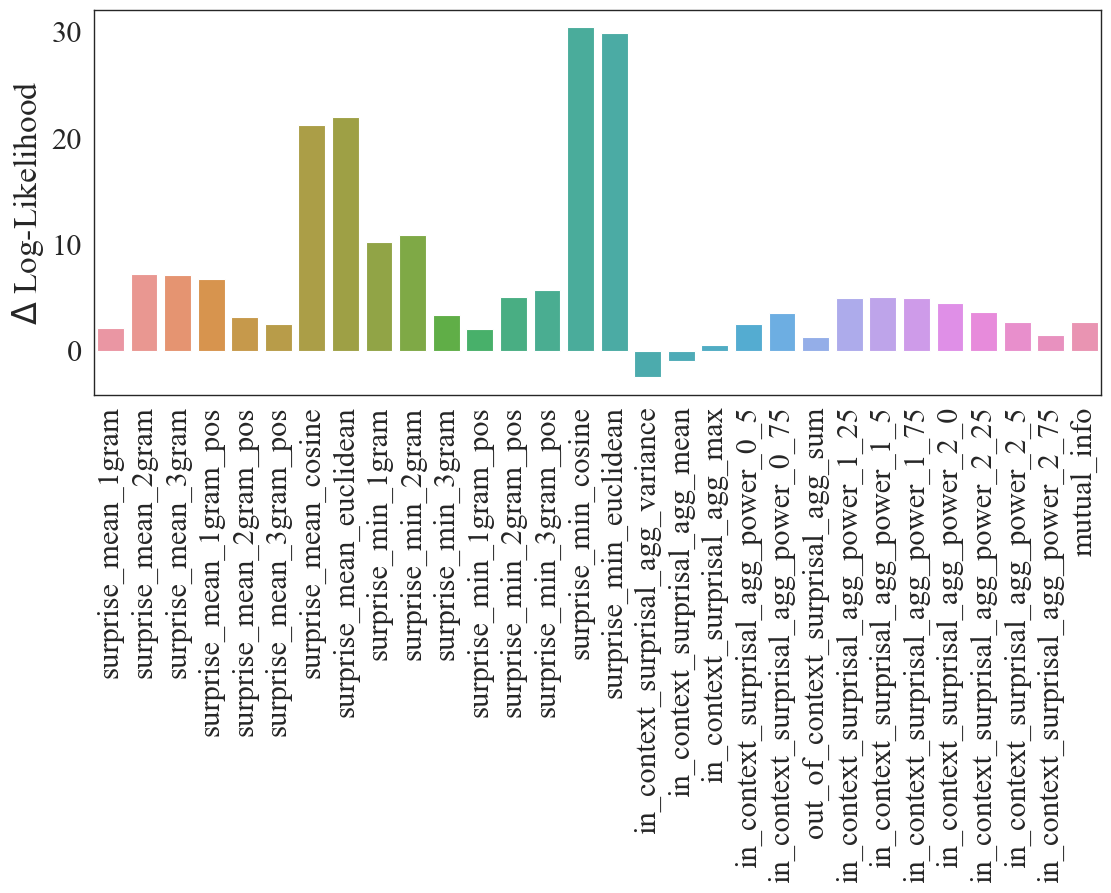

In [28]:
plot_single_predictor_results(dd_single_predictor_df)

In [29]:
dd_single_predictor_df[
    dd_single_predictor_df.Metric.str.contains("surprisal")
].sort_values('Delta Log-Likelihood', ascending=False).head(3)

,Metric,Coefficient,Delta Log-Likelihood,p-value
23,in_context_surprisal_agg_power_1_5,-4.864**,5.083,1.151845e-06
24,in_context_surprisal_agg_power_1_75,-4.954**,4.923,7.278183e-07
22,in_context_surprisal_agg_power_1_25,-4.691**,4.897,2.725265e-06


In [30]:
dd_measures_df = pd.read_csv('../analysis_sec6/dataframes/dd_measures.csv')
top_dd_measure = dd_measures_df[dd_measures_df['Delta Log-Likelihood'] == np.max(dd_measures_df['Delta Log-Likelihood'])]
top_dd_distances = eval(top_dd_measure['Distances'].tolist()[0])
top_dd_distances

['surprise_mean_1gram_pos', 'surprise_min_2gram', 'surprise_min_cosine']

### Joint models

In [31]:
dd_surprisal_baseline_result, dd_surprisal_baseline_rdict = get_mixedlm_results(
    dd_one_df,
    y='judgements',
    X=['in_context_surprisal_agg_power_1_5'],
    group='item_id',
    baseline_rdict=dd_baseline_rdict
)
print(dd_surprisal_baseline_rdict['Delta Log-Likelihood'])
print(dd_surprisal_baseline_result.summary())

5.083234710325314
                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        judgements
No. Observations:        400            Method:                    REML      
No. Groups:              100            Scale:                     0.5233    
Min. group size:         1              Log-Likelihood:            -554.5488 
Max. group size:         7              Converged:                 Yes       
Mean group size:         4.0                                                 
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           3.251    0.283 11.491 0.000  2.697  3.806
in_context_surprisal_agg_power_1_5 -0.007    0.001 -4.864 0.000 -0.009 -0.004
Group Var                           1.113    0.286                

In [32]:
for x in top_dd_distances:
    print(x)
    dd_joint_result, dd_joint_rdict = get_mixedlm_results(
        dd_one_df,
        y='judgements',
        X=['in_context_surprisal_agg_power_1_5', x],
        group='item_id',
        baseline_rdict=dd_baseline_rdict
    )
    pprint(dd_joint_rdict['Delta Log-Likelihood'])


surprise_mean_1gram_pos
8.045193203556664
surprise_min_2gram
10.230975066092924
surprise_min_cosine
26.984811078023085


In [33]:
dd_joint_result, dd_joint_rdict = get_mixedlm_results(
    dd_one_df,
    y='judgements',
    X=['in_context_surprisal_agg_power_1_5'] + top_dd_distances,
    group='item_id',
    # baseline_rdict=dd_surprisal_baseline_rdict
    baseline_rdict=dd_baseline_rdict
)
pprint(dd_joint_rdict['Delta Log-Likelihood'])

30.552425822278565


In [34]:
dd_joint_rdict['Delta Log-Likelihood']

30.552425822278565

In [35]:
### Information value only
dd_iv_result, dd_iv_rdict = get_mixedlm_results(
    dd_one_df,
    y='judgements',
    X=top_dd_distances,
    group='item_id',
    baseline_rdict=dd_baseline_rdict
)
dd_iv_rdict['Delta Log-Likelihood']

35.42116872426277

In [36]:
for x in top_dd_distances:
    print(x)
    dd_joint_result, dd_joint_rdict = get_mixedlm_results(
        dd_one_df,
        y='judgements',
        X=[x],
        group='item_id',
        baseline_rdict=dd_baseline_rdict
    )
    pprint(dd_joint_rdict['Delta Log-Likelihood'])


surprise_mean_1gram_pos
6.707463559301004
surprise_min_2gram
10.875777938071906
surprise_min_cosine
30.407721262307632
